In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2025-sep-dl-gen-ai-project/sample_submission.csv
/kaggle/input/2025-sep-dl-gen-ai-project/train.csv
/kaggle/input/2025-sep-dl-gen-ai-project/test.csv
/kaggle/input/roberta_base/pytorch/final/1/config.json
/kaggle/input/roberta_base/pytorch/final/1/merges.txt
/kaggle/input/roberta_base/pytorch/final/1/tokenizer.json
/kaggle/input/roberta_base/pytorch/final/1/vocab.json
/kaggle/input/roberta_base/pytorch/final/1/tokenizer_config.json
/kaggle/input/roberta_base/pytorch/final/1/model.safetensors
/kaggle/input/roberta_base/pytorch/final/1/special_tokens_map.json


In [2]:
# Wand Db login
import wandb
wandb.login(key="479ac211767b6279f7be89524ecce419e3ae84c6")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 23f1000559 (23f1000559-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Imports

In [3]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from tqdm.auto import tqdm
import numpy as np

2025-11-30 15:51:16.488151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764517876.892903      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764517877.013826      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# loading the dataset
df = pd.read_csv('/kaggle/input/2025-sep-dl-gen-ai-project/train.csv')
test_df = pd.read_csv("/kaggle/input/2025-sep-dl-gen-ai-project/test.csv")

## EDA

In [5]:
# dataset size
print(df.shape)
print(test_df.shape)

(6827, 8)
(1707, 2)


In [6]:
df.head()

,id,text,anger,fear,joy,sadness,surprise,emotions
0,0,the dentist that did the work apparently did a...,1,0,0,1,0,['anger' 'sadness']
1,1,i'm gonna absolutely ~~suck~~ be terrible duri...,0,1,0,1,0,['fear' 'sadness']
2,2,"bridge: so leave me drowning calling houston, ...",0,1,0,1,0,['fear' 'sadness']
3,3,after that mess i went to see my now ex-girlfr...,1,1,0,1,0,['anger' 'fear' 'sadness']
4,4,"as he stumbled i ran off, afraid it might some...",0,1,0,0,0,['fear']


In [7]:
# Avg. Text length
df["text_len"]=df["text"].apply(lambda x: len(x.split()))
print(df["text_len"].mean())
print(df["text_len"].max())
print(df["text_len"].min())

15.684781016551927
89
1


In [8]:
# null values check
df['text'].isna().sum()

0

<Axes: >

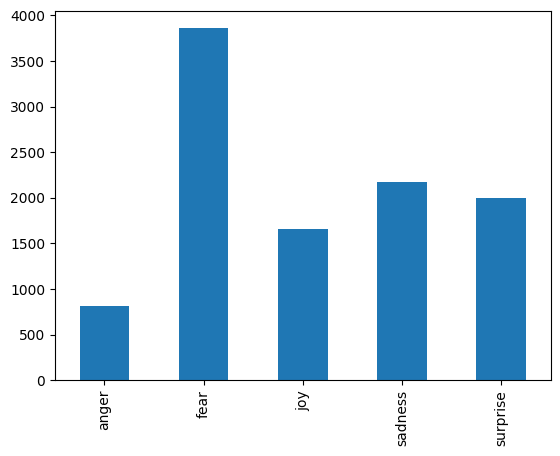

In [9]:
# frequency distribution of each plot
df[["anger","fear","joy","sadness","surprise"]].sum().plot(kind="bar")

<Axes: >

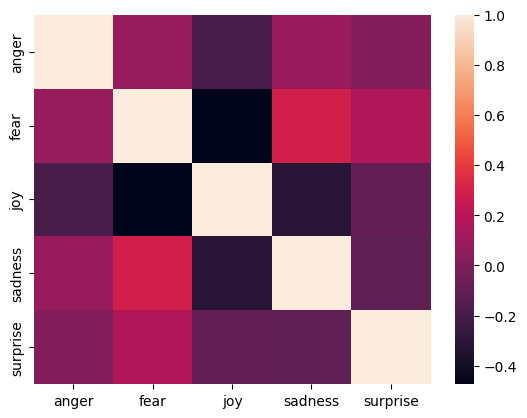

In [10]:
#Coorelation between emotions
import seaborn as sns
sns.heatmap(df[["anger","fear","joy","sadness","surprise"]].corr())

## Data preprocessing

In [11]:
# checking if the dataset has html entities
import re 
html_pat = re.compile(r"&[a-zA-Z0-9#]+;")
df["html_entity"]=df["text"].str.findall(html_pat)
df["html_entity"].value_counts().head(15)

html_entity
[]                6812
[&gt;]               8
[&amp;]              4
[&lt;, &gt;]         1
[&amp;, &amp;]       1
[&lt;]               1
Name: count, dtype: int64

In [12]:
# cleaning html entities
import html
df["text"] = df["text"].apply(html.unescape)

### Converting to Dataset

In [13]:
from datasets import Dataset
test_dataset = Dataset.from_pandas(test_df)


In [14]:
cols = ["anger","fear","joy","sadness","surprise"]
labels = df[cols].astype(float).values

In [15]:
labels

array([[1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       ...,
       [1., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])

In [16]:
dataset = Dataset.from_dict({
    'text': df['text'].tolist(),
    'labels' : labels.tolist()
})

In [17]:
dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
val_dataset = dataset["test"]

## Tokenisation

In [18]:
# model_name = "roberta-base"  
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# def tokenize(batch):
#     return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)


# train_dataset = train_dataset.map(tokenize, batched=True)
# val_dataset = val_dataset.map(tokenize, batched=True)
# test_dataset = test_dataset.map(tokenize, batched=True)

In [19]:
# train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
# val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
# test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])


## Model

In [20]:
# #Model 
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_name,
#     num_labels=5,
#     problem_type="multi_label_classification"
# )

## Training

In [21]:
# training_args = TrainingArguments(
#     output_dir="./results",
#     report_to = "wandb",
#     run_name="roberta-base-threshold",
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     learning_rate=2e-5,
#     num_train_epochs=10,
#     logging_steps=200,
#     gradient_accumulation_steps=2
# )

In [22]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     tokenizer=tokenizer,
# )

# trainer.train()

## Saving

In [23]:
# # save the model and tokeniser
# model.save_pretrained("model-roberta-final")
# tokenizer.save_pretrained("model-roberta-final")
# #zipping the folder
# import shutil
# shutil.make_archive("model-roberta-final", 'zip', "model-roberta-final")

# # uplaod the model to kagglehub
# import kagglehub

# handle = "m7krun/roberta_base/pyTorch/final"

# kagglehub.model_upload(
#     handle,
#     "model-roberta-final.zip",
#     version_notes="final model"
# )

# print("Uploaded:", handle)


## Downloading Model

In [24]:
import kagglehub
handle = "m7krun/roberta_base/pyTorch/final"
model_dir = kagglehub.model_download(handle)

## Inference

In [25]:
#tokeniser and model
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

In [26]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

test_dataset = test_dataset.map(tokenize, batched=True)


Map:   0%|          | 0/1707 [00:00<?, ? examples/s]

In [27]:
#trainer
inference_args = TrainingArguments(
    output_dir="./inference_roberta",
    per_device_eval_batch_size=16,
    dataloader_drop_last=False,
    report_to="wandb",
)

trainer = Trainer(
    model=model,
    args=inference_args,
    tokenizer=tokenizer,
)

/tmp/ipykernel_20/3152629647.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Preds

In [28]:
thresholds= [0.280, 0.140, 0.700, 0.800, 0.260]
preds = trainer.predict(test_dataset)
probs = torch.sigmoid(torch.tensor(preds.predictions)).numpy()

if probs.shape[0] == 5:
    probs = probs.T

binary_preds = np.zeros_like(probs)

for i, t in enumerate(thresholds):
    binary_preds[:, i] = (probs[:, i] > t).astype(int)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.20.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251130_155151-e0p8jp29
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./inference_roberta
wandb: ⭐️ View project at https://wandb.ai/23f1000559-indian-institute-of-technology-madras/huggingface
wandb: 🚀 View run at https://wandb.ai/23f1000559-indian-institute-of-technology-madras/huggingface/runs/e0p8jp29


In [29]:
# submission
output = pd.DataFrame(binary_preds, columns=["anger", "fear", "joy", "sadness", "surprise"])
output.insert(0, "id", test_df["id"])
output.to_csv("submission.csv", index=False)

In [30]:
!head -n 5 submission.csv
!wc -l submission.csv

id,anger,fear,joy,sadness,surprise
0,1.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
1708 submission.csv


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
